## Birectional LSTM model for audio labeling with Keras

![](https://camo.githubusercontent.com/71098172b2e99002427c06aa95eb7fdc7252519f/68747470733a2f2f626c6f672e66726565736f756e642e6f72672f77702d636f6e74656e742f75706c6f6164732f323031372f31322f757064617465645f6c6f676f2e706e67)

In this Kaggle kernel we will use the curated data from the "Freesound Audio Tagging 2019" competition to predict the labels of .wav files. 

## Table of contents

- [Data Description](#1)
- [Dependencies](#2)
- [Evaluation Metric](#3)
- [Helper Functions and Preprocessing](#4)
- [Modeling](#5)
- [Visualization and Evaluation](#6)
- [Predictions and Submission](#7)
- [Final Checks](#8)

## Data Description <a id="1"></a>

From [Kaggle's data page](https://www.kaggle.com/c/freesound-audio-tagging-2019/data) for the competition:

The curated subset is a small set of manually-labeled data from FSD.

Number of clips/class: 75 except in a few cases (where there are less)

Total number of clips: 4970

Avge number of labels/clip: 1.2

Total duration: 10.5 hours

The duration of the audio clips ranges from 0.3 to 30s due to the diversity of the sound categories and the preferences of Freesound users when recording/uploading sounds. It can happen that a few of these audio clips present additional acoustic material beyond the provided ground truth label(s).

**Test Set:**

The test set is used for system evaluation and consists of manually-labeled data from FSD. Since most of the train data come from YFCC, some acoustic domain mismatch between the train and test set can be expected. All the acoustic material present in the test set is labeled, except human error, considering the vocabulary of 80 classes used in the competition.

**Columns:**

*fname*: the audio file name, eg, 0006ae4e.wav
*labels*: the audio classification label(s) (ground truth). Note that the number of labels per clip can be one, eg, Bark or more, eg, "Walk_and_footsteps,Slam".

## Dependencies <a id="2"></a>

In [1]:
# Dependencies
import numpy as np 
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split

# Machine Learning
import tensorflow as tf
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Dense, Bidirectional, CuDNNLSTM, ELU,
                          Dropout, LeakyReLU, Conv1D, BatchNormalization)
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Path specifications
KAGGLE_DIR = '../input/'
train_curated_path = KAGGLE_DIR + 'train_curated/'
test_path = KAGGLE_DIR + 'test/'

# Set seed for reproducability
seed = 1234
np.random.seed(seed)
tf.set_random_seed(seed)

# File sizes and specifications
print('\n# Files and file sizes')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))

# For keeping time. GPU limit for this competition is set to 60 min.
t_start = time.time()


# Files and file sizes
train_curated.csv             | 0.14 MB
train_noisy.csv               | 0.58 MB
test                          | 0.04 MB
sample_submission.csv         | 0.19 MB
train_curated                 | 0.14 MB
train_noisy                   | 0.55 MB


Using TensorFlow backend.


## Evaluation metric <a id="3"></a>

From the [competition evaluation page](https://www.kaggle.com/c/freesound-audio-tagging-2019/overview/evaluation):

The task consists of predicting the audio labels (tags) for every test clip. Some test clips bear one label while others bear several labels. The predictions are to be done at the clip level, i.e., no start/end timestamps for the sound events are required.

The primary competition metric will be label-weighted [label-ranking average precision](https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision) (lwlrap, pronounced "Lol wrap"). This measures the average precision of retrieving a ranked list of relevant labels for each test clip (i.e., the system ranks all the available labels, then the precisions of the ranked lists down to each true label are averaged). This is a generalization of the mean reciprocal rank measure (used in last year’s edition of the competition) for the case where there can be multiple true labels per test item. The novel "label-weighted" part means that the overall score is the average over all the labels in the test set, where each label receives equal weight (by contrast, plain lrap gives each test item equal weight, thereby discounting the contribution of individual labels when they appear on the same item as multiple other labels).

The formula for label-ranking average precision (LRAP) is as follows:

$LRAP(y, \hat{f}) = \frac{1}{n_{\text{samples}}}
  \sum_{i=0}^{n_{\text{samples}} - 1} \frac{1}{||y_i||_0}
  \sum_{j:y_{ij} = 1} \frac{|\mathcal{L}_{ij}|}{\text{rank}_{ij}}$

Happily, the evaluation metric is provided by Kaggle and can be found in this [Google Colab file](https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=52LPXQNPppex).

In [2]:
def calculate_overall_lwlrap_sklearn(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

## Helper Functions and Preprocessing <a id="4"></a>

I got the inspiration for most of the preprocessing steps and the attention layer from [this Kaggle kernel](https://www.kaggle.com/chewzy/gru-w-attention-baseline-model-curated).

In [3]:
n_classes = 80

def split_and_label(rows_labels, n_classes):
    '''
    Retrieves a list of all the relevant classes. This is necessary due to 
    the multi-labeling of the initial csv file.
    '''
    row_labels_list = []
    for row in rows_labels:
        row_labels = row.split(',')
        labels_array = np.zeros((n_classes))
        for label in row_labels:
            index = label_mapping[label]
            labels_array[index] = 1
        row_labels_list.append(labels_array)
    return row_labels_list

In [4]:
# Load in data
df = pd.read_csv(KAGGLE_DIR + 'train_curated.csv')
test_df = pd.read_csv(KAGGLE_DIR + 'sample_submission.csv')

# Retrieve labels
label_columns = test_df.columns[1:]
label_mapping = dict((label, index) for index, label in enumerate(label_columns))
for col in label_columns:
    df[col] = 0  
df[label_columns] = split_and_label(df['labels'], n_classes)
df['num_labels'] = df[label_columns].sum(axis=1)

In [5]:
# Check dataframes
print('Training dataframe:')
display(df.head(3))
print('Testing dataframe:')
test_df.head(3)

Training dataframe:


,fname,labels,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,...,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing),num_labels
0,0006ae4e.wav,Bark,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0019ef41.wav,Raindrop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,001ec0ad.wav,Finger_snapping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Testing dataframe:


,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0012633b.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,001ed5f1.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Preprocessing parameters
sr = 44100 # Sampling rate
duration = 5
hop_length = 347 # to make time steps 128
fmin = 20
fmax = sr // 2
n_mels = 128
n_fft = n_mels * 20
samples = sr * duration

In [7]:
def read_audio(path):
    '''
    Reads in the audio file and returns
    an array that we can turn into a melspectogram
    '''
    y, _ = librosa.core.load(path, sr=44100)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)
    if len(y) > samples: # long enough
        y = y[0:0+samples]
    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(audio):
    '''
    Convert to melspectrogram after audio is read in
    '''
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=sr,
                                                 n_mels=n_mels,
                                                 hop_length=hop_length,
                                                 n_fft=n_fft,
                                                 fmin=fmin,
                                                 fmax=fmax)
    return librosa.power_to_db(spectrogram).astype(np.float32)

def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    mels = audio_to_melspectrogram(read_audio(path))
    return mels

def convert_wav_to_image(df, path):
    X = []
    for _,row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram('{}/{}'.format(path[0],
                                                  str(row['fname'])))
        X.append(x.transpose())
    return X

def normalize(img):
    '''
    Normalizes an array 
    (subtract mean and divide by standard deviation)
    '''
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img

def normalize_dataset(X):
    '''
    Normalizes list of arrays
    (subtract mean and divide by standard deviation)
    '''
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
    return normalized_dataset

In [8]:
# Preprocess dataset and create validation sets
X = np.array(convert_wav_to_image(df, [train_curated_path]))
X = normalize_dataset(X)
Y = df[label_columns].values
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=seed)

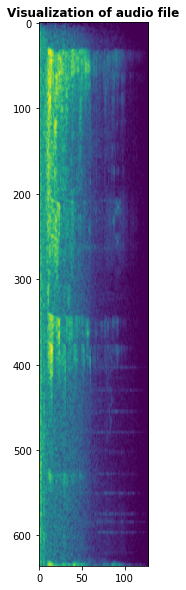

In [9]:
# Visualize an melspectogram example
plt.figure(figsize=(15,10))
plt.title('Visualization of audio file', weight='bold')
plt.imshow(X[0]);

## Modeling <a id="5"></a>

My main inspiration for this architecture has been [this paper](https://arxiv.org/pdf/1602.05875v3.pdf).

In [10]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [11]:
# Neural network model
input_shape = (636,128)
optimizer = Adam(0.005, beta_1=0.1, beta_2=0.001, amsgrad=True)
n_classes = 80

model = Sequential()
model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True), input_shape=input_shape))
model.add(Attention(636))
model.add(Dropout(0.2))
model.add(Dense(400))
model.add(ELU())
model.add(Dropout(0.2)) 
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# Train model
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10)
hist = model.fit(np.array(x_train),
          y_train,
          batch_size=1024,
          epochs=500,
          validation_data=(np.array(x_val), y_val),
          callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Train on 4473 samples, validate on 497 samples
Epoch 1/500
4473/4473 [==============================] - 12s 3ms/step - loss: 4.8638 - acc: 0.0483 - val_loss: 4.4624 - val_acc: 0.0986
Epoch 2/500
4473/4473 [==============================] - 6s 1ms/step - loss: 4.4178 - acc: 0.1008 - val_loss: 4.1836 - val_acc: 0.1167
Epoch 3/500
4473/4473 [==============================] - 6s 1ms/step - loss: 4.0545 - acc: 0.1567 - val_loss: 4.0502 - val_acc: 0.1529
Epoch 4/500
4473/4473 [==============================] - 6s 1ms/step - loss: 3.8491 - acc: 0.1827 - val_loss: 3.7245 - val_acc: 0.1811
Epoch 5/500
4473/4473 [==============================] - 6s 1ms/step - loss: 3.7089 - acc: 0.2077 - val_loss: 3.6501 - val_acc: 0.1972
Epoch 6/500
4473/4473 [==============================] - 6s 1ms/step - loss: 3.5312 - acc: 0.2397 - val_loss: 3.5270 - val_acc: 0.2274
Epoch 7/500
4473/4473 [==============================] - 6s 1ms/step - loss: 3.3873 - acc: 0.2

## Visualization and Evaluation <a id="6"></a>

Simple visualizations to keep track of the loss and accuracy over the epochs.

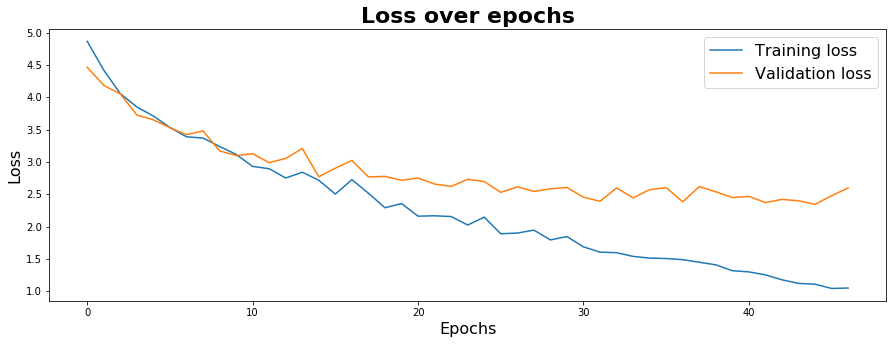

In [13]:
# Visualize loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']
stopped_epoch = es.stopped_epoch
epochs = range(stopped_epoch+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()

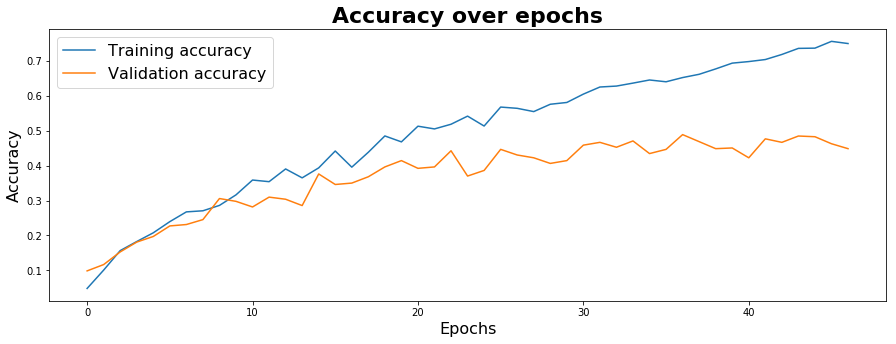

In [14]:
# Visualize Accuracy
acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(stopped_epoch+1)

plt.figure(figsize=(15,5))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

**Training accuracy LWLRAP score:**

In [15]:
# Make predictions for training set and validation set
y_train_pred = model.predict(np.array(x_train))
y_val_pred = model.predict(np.array(x_val))
train_lwlrap = calculate_overall_lwlrap_sklearn(y_train, y_train_pred)
val_lwlrap = calculate_overall_lwlrap_sklearn(y_val, y_val_pred)

# Check training and validation LWLRAP score
print('Training LWLRAP : {}'.format(round(train_lwlrap,4)))
print('Validation LWLRAP : {}'.format(round(val_lwlrap,4)))

Training LWLRAP : 0.8752
Validation LWLRAP : 0.6121


## Predictions and submission <a id="7"></a>

Preprocess the test set, make predictions and store them as a csv file for our submission.

In [16]:
# Prepare test set
X_test = np.array(convert_wav_to_image(test_df, [test_path]))
X_test = normalize_dataset(X_test)
# Make predictions
predictions = model.predict(np.array(X_test))
# Save predictions in a csv file
test_df[label_columns] = predictions
test_df.to_csv('submission.csv', index=False)

## Final checks <a id="8"></a>

Lastly, we check if the submission format is correct and if we are under the one hour limit of GPU time.

In [17]:
# Check submission format
display(test_df.head())

# Check if we are under one hour of GPU time
t_finish = time.time()
total_time = round((t_finish-t_start)/3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, 
                                                      int(total_time*60)))

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0.000161,0.000009,7.580730e-05,2.552045e-04,0.001516,1.424048e-02,0.000185,0.000646,9.578727e-03,7.919710e-05,0.000191,2.632578e-03,1.625137e-04,4.771038e-04,0.002467,0.000082,2.423917e-02,0.007304,0.000017,3.402441e-03,0.008352,7.225134e-04,0.117118,6.555997e-05,1.534828e-03,0.013286,0.009195,0.000083,0.020046,4.884481e-05,2.628672e-03,0.000262,0.002762,0.000206,2.045473e-01,0.000544,2.283409e-04,4.468651e-04,0.000108,...,0.000525,4.592218e-02,0.002518,0.373520,5.398309e-04,0.000186,1.626895e-04,5.206588e-05,0.004002,1.341431e-05,2.625939e-04,7.376210e-05,1.120076e-03,8.403853e-05,0.000143,0.019352,1.988180e-04,0.080431,3.242536e-05,3.852779e-03,4.105820e-05,0.000111,4.058110e-05,0.000109,0.000033,0.000092,9.515691e-04,6.022883e-05,0.003428,0.000493,0.000017,1.289604e-04,0.000137,0.000346,0.000139,4.047037e-05,0.007918,0.001513,0.000339,0.000396
1,0012633b.wav,0.091847,0.000155,8.812740e-05,5.745049e-05,0.001546,1.314537e-04,0.002467,0.026066,2.033709e-02,1.036953e-05,0.003438,2.469083e-01,4.361063e-04,2.938230e-05,0.001632,0.000397,2.075559e-06,0.009200,0.004784,3.974987e-06,0.000106,3.825120e-04,0.255447,5.691873e-05,1.165228e-04,0.000190,0.000004,0.001921,0.000068,4.819703e-04,1.469645e-05,0.023674,0.000377,0.023763,4.980637e-06,0.002593,1.642484e-04,2.672241e-05,0.000354,...,0.000808,2.885662e-05,0.197859,0.000098,1.279027e-06,0.000077,1.242110e-03,5.708583e-05,0.003968,9.622281e-04,1.548302e-03,4.981272e-02,1.046895e-04,2.366013e-03,0.000479,0.000032,7.151283e-05,0.001639,9.764637e-05,1.056410e-05,5.993796e-03,0.000477,4.365761e-06,0.000167,0.000764,0.000540,2.066539e-04,4.343721e-04,0.000004,0.000048,0.001526,5.682121e-04,0.000040,0.000973,0.000782,1.228718e-03,0.000643,0.000245,0.000256,0.002346
2,001ed5f1.wav,0.000046,0.000007,1.403562e-05,5.386537e-05,0.000021,3.404069e-03,0.000040,0.000028,1.004338e-07,2.589566e-05,0.000022,7.730521e-07,9.424301e-07,6.040038e-05,0.000339,0.005438,1.628301e-03,0.000001,0.000008,9.784693e-04,0.000575,1.202442e-03,0.000002,5.392555e-05,2.452281e-02,0.005565,0.004249,0.000499,0.000004,3.414672e-04,9.181667e-01,0.000005,0.000005,0.000068,2.619581e-05,0.000015,4.767644e-05,2.165857e-06,0.000017,...,0.000009,1.002554e-03,0.000029,0.001735,5.968400e-03,0.000060,2.490886e-05,2.865228e-06,0.000034,6.943598e-07,2.744647e-04,5.668546e-07,1.759027e-03,2.341372e-06,0.000020,0.000002,3.930481e-03,0.001406,2.357088e-06,4.382219e-03,1.554717e-03,0.000100,1.185252e-04,0.001021,0.000052,0.000147,7.368742e-06,7.225769e-06,0.000090,0.000388,0.000052,1.214538e-05,0.000112,0.005821,0.000022,6.172647e-06,0.000396,0.000965,0.000007,0.000854
3,00294be0.wav,0.000003,0.000001,8.072470e-07,7.080239e-08,0.000127,2.750577e-07,0.000001,0.000275,3.449944e-07,1.083707e-04,0.000007,1.600500e-03,8.939513e-06,1.040001e-07,0.000091,0.000014,5.649224e-07,0.000035,0.000002,4.697334e-08,0.000008,4.647279e-07,0.000023,1.898525e-07,6.352453e-07,0.000005,0.0000

Kernel runtime = 0.2056 hours (12 minutes)


**If you like this Kaggle kernel, feel free to give an upvote and leave a comment! I will try to implement your suggestions in this kernel!**